<a href="https://colab.research.google.com/github/goya5858/OSERO/blob/main/Check_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/OTHELLO

[Errno 2] No such file or directory: '/content/drive/MyDrive/OTHELLO'
/workspace


In [1]:
import pandas as pd
import gc
import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm
import copy
from torch.utils.data import Dataset, DataLoader
import torch

from torch.nn import Conv2d, Linear, ReLU, Dropout
from torch.nn import Module
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import KFold

from torch.optim import Adam
from sklearn.metrics import accuracy_score

# Datset

In [ ]:
#data = pd.read_csv('Othello_Kihu.txt', header=None, sep=' ')
#data = data.sample(100)
#data = data[data[64]!=0]
#data = data.drop_duplicates()
#data
#data = data[data[64]!=0] #石を置けない場合(0, 0)のactionをとるが、データ数が１だけなので除外する

In [3]:
#DEBUG = True

#data = pd.read_csv('Othello_Kihu.txt', header=None, sep=' ')
#data = data[data[64]!=0] #石を置けない場合(0, 0)のactionをとるが、データ数が１だけなので除外する
#data.iloc[:, :64] = data.iloc[:, :64].where( data.iloc[:, :64] != 2, -1) # 黒 : -1, 白 : 1, 何もなし : 0　の 8*8 の盤面を持つ　ようにする
#cols = [ i for i in range(64)]
#data.loc[data[66]=='B', cols] = data.loc[data[66]=='B', cols]*-1 # 黒手番の場合、自分と相手を入れ替える　モデルが理解しやすいように
#data = data.drop_duplicates()
#data.to_csv('drop_dups.csv', index=False)
#
#if DEBUG:
#    data = data.sample(n=10000)

data = pd.read_csv('sample_kifu.csv')
data.columns = data.columns.astype(np.int)


data.iloc[:, :64] = data.iloc[:, :64].where( data.iloc[:, :64] != 2, -1) # 黒 : -1, 白 : 1, 何もなし : 0　の 8*8 の盤面を持つ　ようにする
cols = [ i for i in range(64)]
data.loc[data[66]=='B', cols] = data.loc[data[66]=='B', cols]*-1 # 黒手番の場合、自分と相手を入れ替える　モデルが理解しやすいように
gc.collect()

print(data.shape)
data.head()

(100, 68)


,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,0,0,0,0,0,-1,0,0,0,0,...,0,0,0,0,0,0,3,1,B,42
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,3,B,60
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,6,W,57
3,0,0,-1,-1,-1,0,0,0,0,0,...,0,1,0,-1,0,0,7,2,B,20
4,1,1,1,1,1,1,1,1,0,1,...,1,1,1,1,0,0,8,6,B,8


In [5]:
class OCDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.States = df.iloc[:, :64] #盤面
        self.player = df.iloc[:, 66] #W or B
        self.action = 8*(df.iloc[:, 65]-1) + (df.iloc[:, 64]-1) #0-63のどこに置くか

    def __len__(self):
        return self.States.shape[0]

    def __getitem__(self, idx):
        state_can = np.zeros((8,8))
        state = self.States.iloc[idx].values.reshape(8,8)

        state_my = (state == 1).astype(np.uint8) #自分の石の位置
        state_op = (state == -1).astype(np.uint8) #相手の石の位置
        state_on = (state != 0).astype(np.uint8)   # 盤面の石の位置
        states = np.stack( [state_on, state_op, state_my] )

        states = torch.tensor( states, dtype=torch.float32 )
        action = torch.tensor( self.action.iloc[idx], dtype=torch.int64 )

        return states, action, self.player.iloc[idx]

# ここから先はコピーして、Datasetだけ変えて実行してください

In [6]:
sample_dataset = OCDataset(data)

sample_loader = DataLoader(
        dataset = sample_dataset,
        batch_size=100,
        shuffle=False
        )

States, Actions, _ = iter(sample_loader).next()

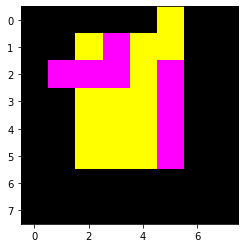

Answer : 2



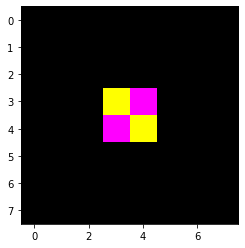

Answer : 19



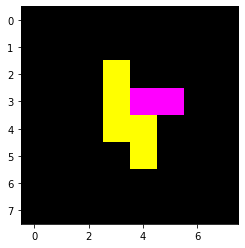

Answer : 42



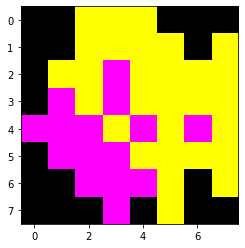

Answer : 14



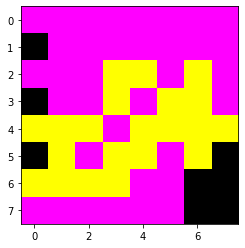

Answer : 47



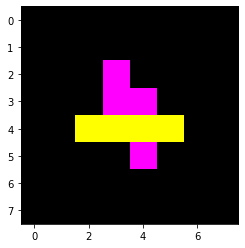

Answer : 45



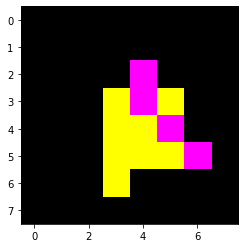

Answer : 38



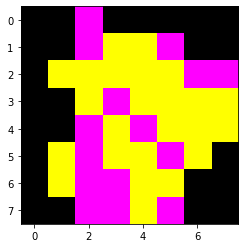

Answer : 3



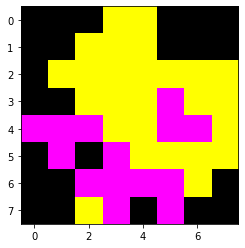

Answer : 25



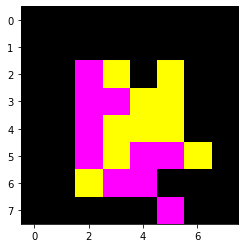

Answer : 58



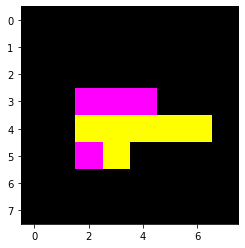

Answer : 51



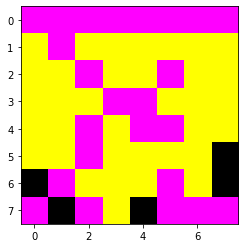

Answer : 60



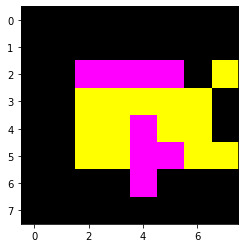

Answer : 17



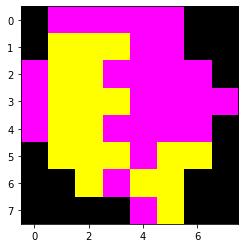

Answer : 59



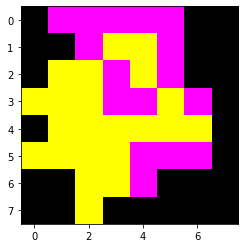

Answer : 59



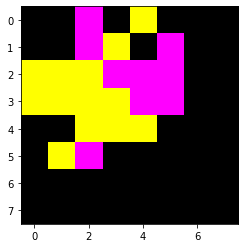

Answer : 12



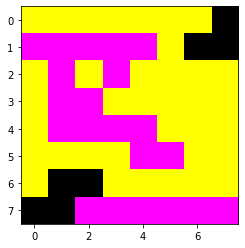

Answer : 14



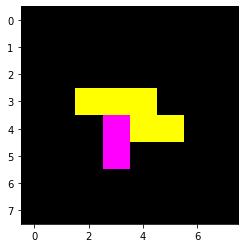

Answer : 19



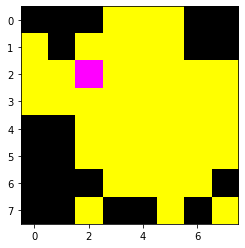

Answer : 50



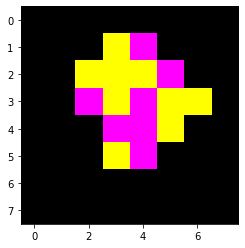

Answer : 22



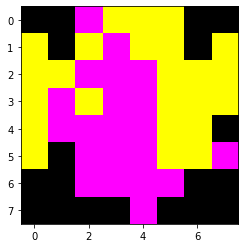

Answer : 6



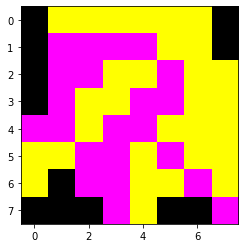

Answer : 56



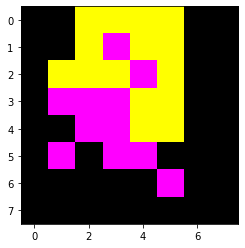

Answer : 16



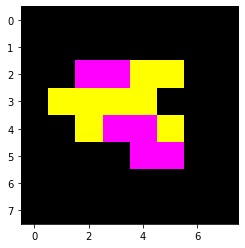

Answer : 33



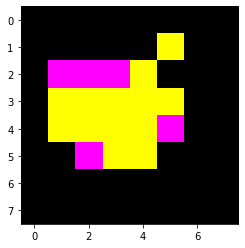

Answer : 51



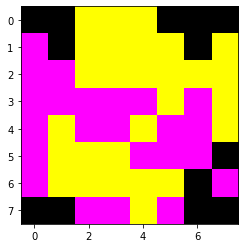

Answer : 56



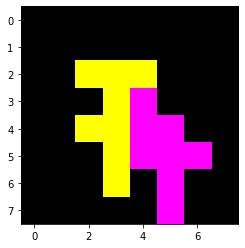

Answer : 50



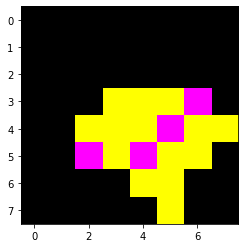

Answer : 20



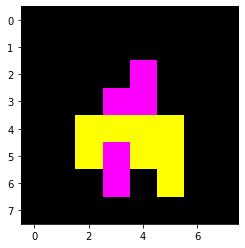

Answer : 52



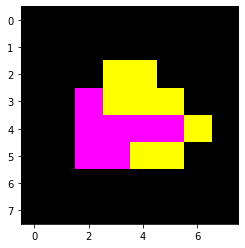

Answer : 18



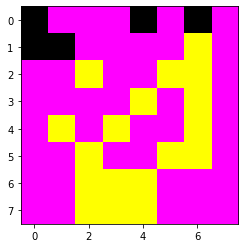

Answer : 6



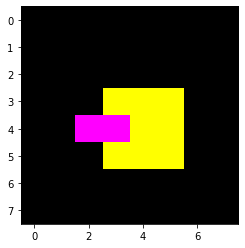

Answer : 19



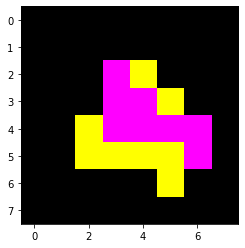

Answer : 52



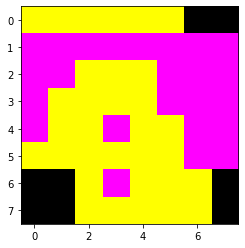

Answer : 63



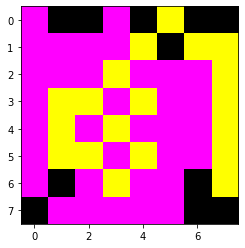

Answer : 7



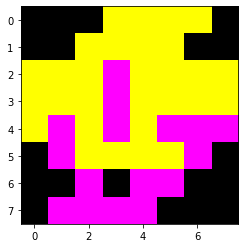

Answer : 1



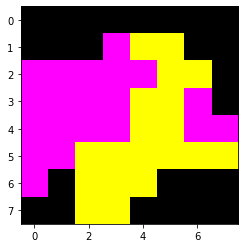

Answer : 5



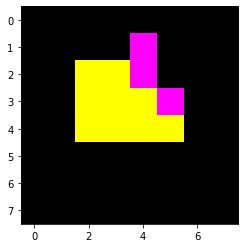

Answer : 45



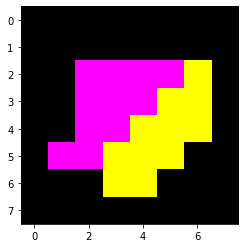

Answer : 23



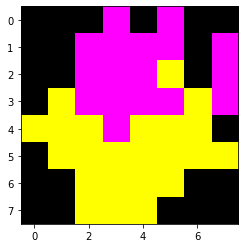

Answer : 22



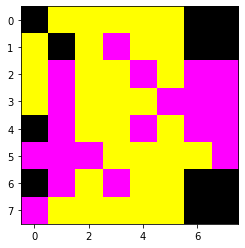

Answer : 62



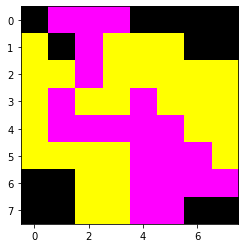

Answer : 57



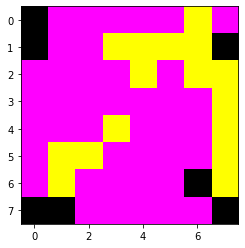

Answer : 15



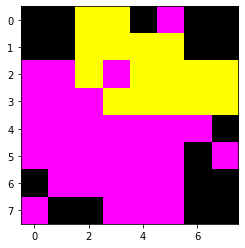

Answer : 9



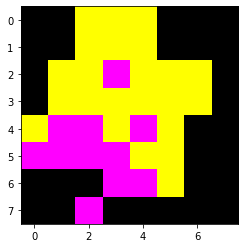

Answer : 24



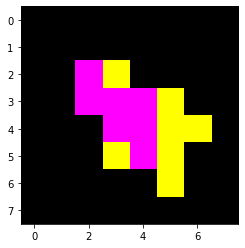

Answer : 51



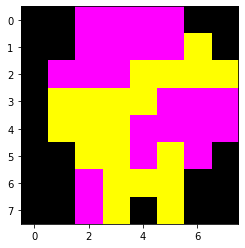

Answer : 24



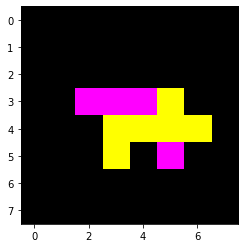

Answer : 21



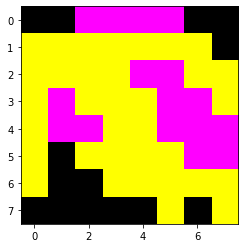

Answer : 62



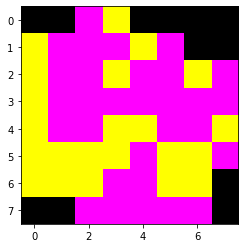

Answer : 56



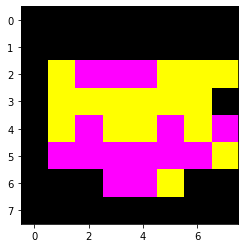

Answer : 31



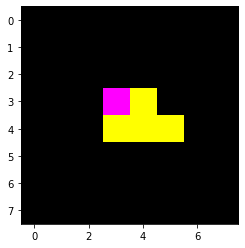

Answer : 45



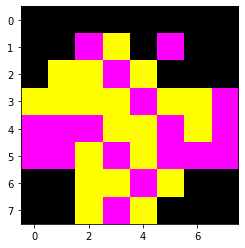

Answer : 49



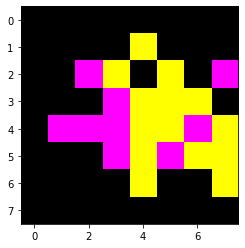

Answer : 53



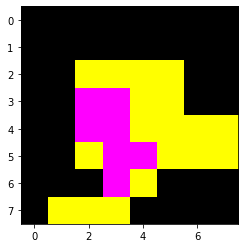

Answer : 50



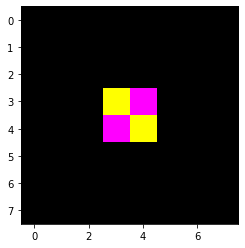

Answer : 44



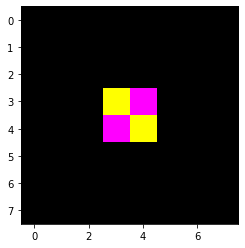

Answer : 37



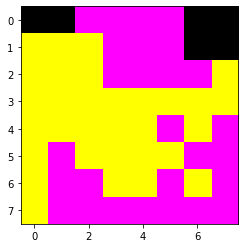

Answer : 0



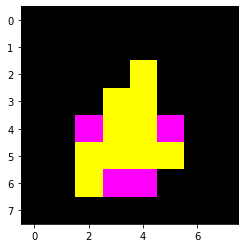

Answer : 19



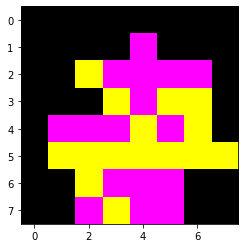

Answer : 26



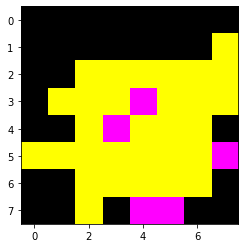

Answer : 10



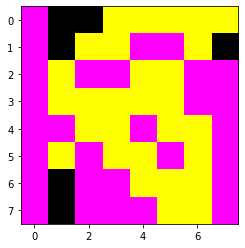

Answer : 15



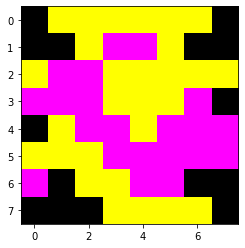

Answer : 57



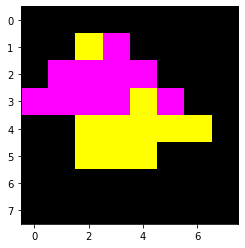

Answer : 45



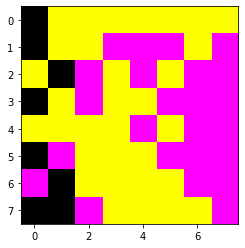

Answer : 49



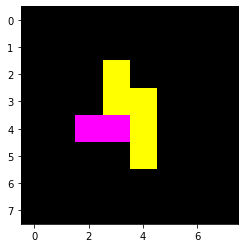

Answer : 37



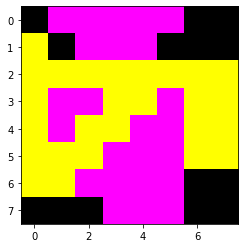

Answer : 13



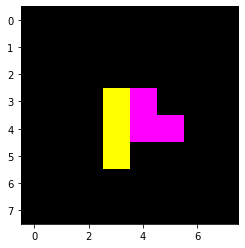

Answer : 34



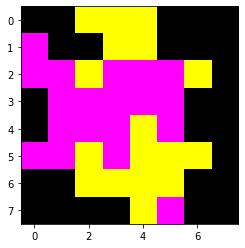

Answer : 10



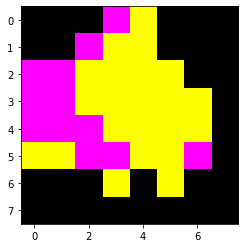

Answer : 48



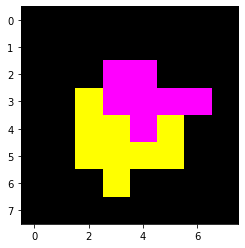

Answer : 38



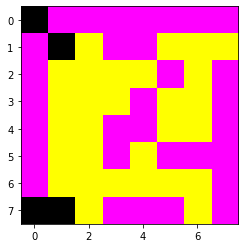

Answer : 56



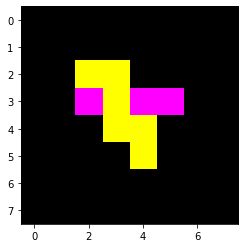

Answer : 43



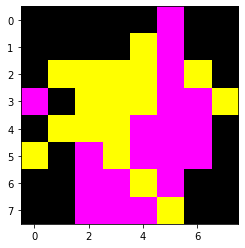

Answer : 62



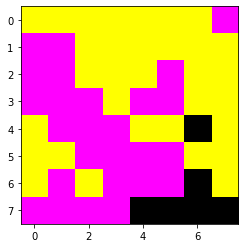

Answer : 63



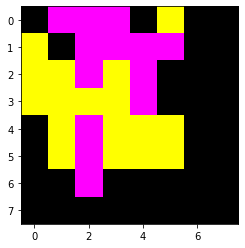

Answer : 51



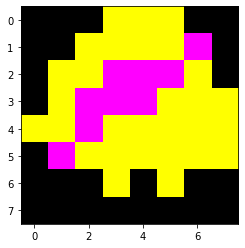

Answer : 24



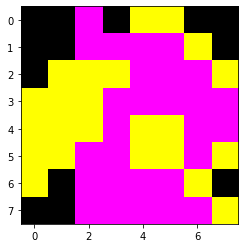

Answer : 55



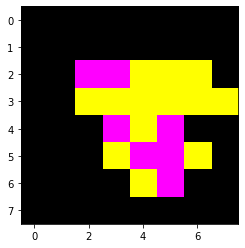

Answer : 13



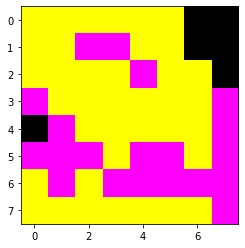

Answer : 32



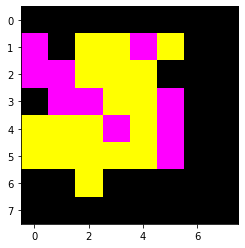

Answer : 21



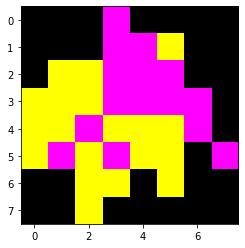

Answer : 46



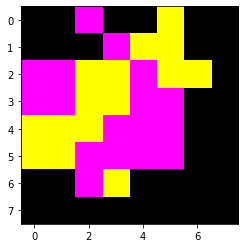

Answer : 48



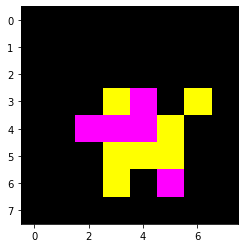

Answer : 52



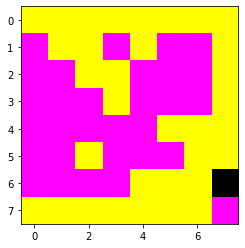

Answer : 55



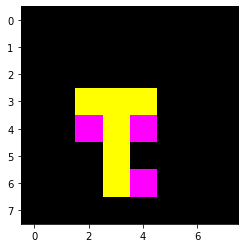

Answer : 18



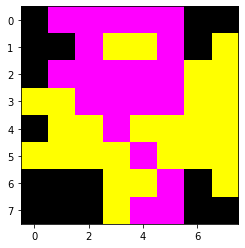

Answer : 58



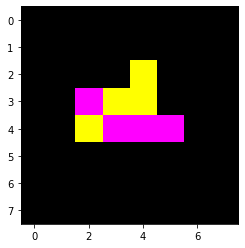

Answer : 29



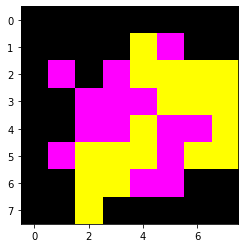

Answer : 5



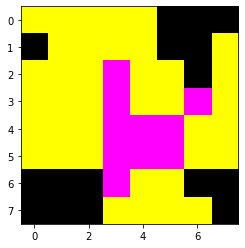

Answer : 49



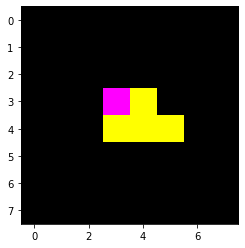

Answer : 43



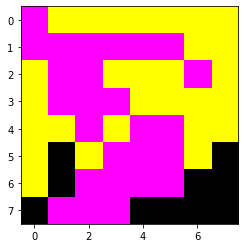

Answer : 41



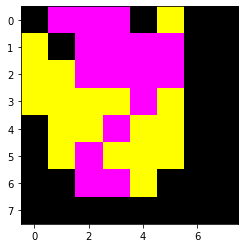

Answer : 22



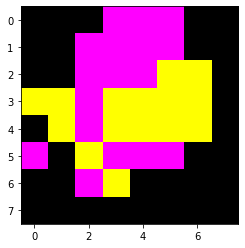

Answer : 41



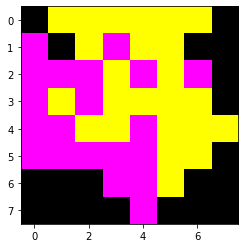

Answer : 23



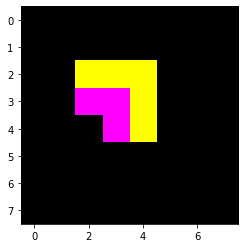

Answer : 11



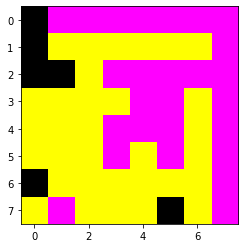

Answer : 61



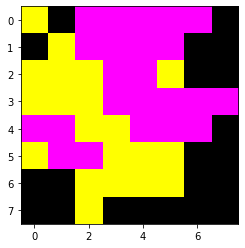

Answer : 22



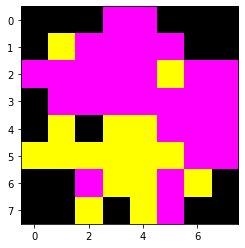

Answer : 0



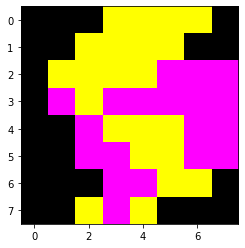

Answer : 63



In [7]:
for i in range(100):
    plt.imshow( States[i].detach().numpy().transpose(1,2,0) )
    plt.show()
    print("Answer :", Actions[i].detach().numpy())
    print("="*30, "\n")